## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

CSDN - Earlystopping 的使用與技巧
<pre>

為何要使用 EarlyStopping：繼續訓練會導致測試集準確率下降。

過度擬合
學習率過大導致不收斂
使用 Regulizers 時，Loss 減少未必是準確率上升，可能是 weights 變少而已。


EarlyStopping 可以監控的項目

acc, val_acc, loss, val_loss, ...etc 等 loss 與 metrics


有時候要監控的項目不是越小越好 (“min”)，這時候要可以手動將 mode 設成 “max”

</pre>



參考連結：

1. [Keras 的 EarlyStopping callbacks的使用與技巧 – CSND blog](https://blog.csdn.net/silent56_th/article/details/72845912)

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/alison/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 25]

In [8]:
from keras.callbacks import EarlyStopping


results = {}

for patience in PATIENCE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment patience of Early Stopping = %d" % (patience))
    
    earlystop = EarlyStopping(monitor="val_loss", patience=patience, verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "patience-%s" % (str(patience))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment patience of Early Stopping = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (Non

50000/50000 [==============================] - 6s 121us/step - loss: 1.3052 - acc: 0.5451 - val_loss: 1.4907 - val_acc: 0.4757
Epoch 11/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.2772 - acc: 0.5572 - val_loss: 1.4821 - val_acc: 0.4777
Epoch 12/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.2499 - acc: 0.5663 - val_loss: 1.4791 - val_acc: 0.4784
Epoch 13/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.2256 - acc: 0.5751 - val_loss: 1.4678 - val_acc: 0.4850
Epoch 14/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2004 - acc: 0.5856 - val_loss: 1.4612 - val_acc: 0.4883
Epoch 15/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.1770 - acc: 0.5938 - val_loss: 1.4670 - val_acc: 0.4872
Epoch 16/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.1533 - acc: 0.6030 - val_loss: 1.4544 - val_acc: 0.4874
Epoch 17/50
50000/50000 [==============

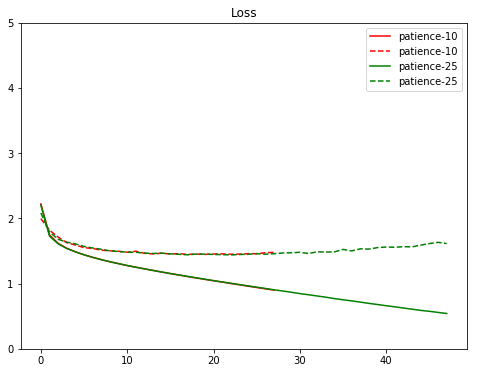

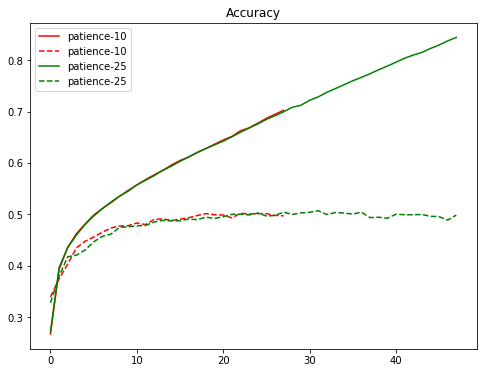

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()